# GRF potential inhomogeneties inference starting guide

This notebook shows basic examples of using _Herculens_ for lensing simulation, checking distributions of random variables, example of grid search-based GRF inference and gradient descent-based GRF inference.

__Notebook author__: @egorssed

__Herculens authors__: @austinpeel, @aymgal

__last updated__: 6/03/22


In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

# Basic imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math
from functools import partial

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#CPUs parallelization
import multiprocessing
max_thread_numbers=multiprocessing.cpu_count()
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(max_thread_numbers)

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Observed gravitational lens

Let's assume that we used HST for lens finding and we observed the following Einstein ring $I(x,y)$ with perturbation-like anomalies on it.
Our goal is to infer the statistical properties of these gravitational potential inhomogeneities $\delta \psi$ that induced these anomalies.
We model these inhomogeneities $\delta \psi$ as a Gaussian Random Field, that is defined by its power spectrum $P_{\delta \psi}=A \cdot k^{-\beta}$ and random seed $\phi$
We are interested in inference of power spectrum $P_{\delta \psi}$, so we will always sample several realisations of $\phi$ and treat corresponding variation as an additional noise
spoiler: for this mock observation $log(A)=-7.6$ , $\beta=2$, $\phi=0$

In [5]:
#Observation conditions
PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure time for Poisson noise
SNR=200 #75th percentile of COSMOS dataset's distribution of Peak-SNR for Background noise

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_90531/186220466.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


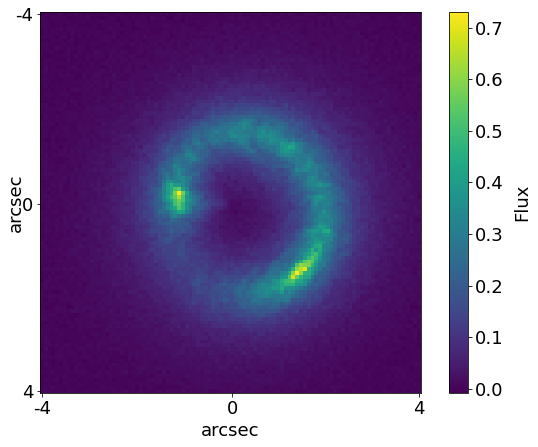

In [3]:
#Observed image
Observed_image=np.load('./data/Observation example.npy')

#Figure
fig,axis=plt.subplots(1,1,figsize=(10,7))
img=axis.imshow(Observed_image)
cbar=fig.colorbar(img,ax=axis,fraction=0.045)
cbar.ax.tick_params(labelsize=FS)
cbar.ax.set_ylabel('Flux',rotation=90,fontsize=FS,labelpad=10)
axis.set_xticks([0,50,100-1])
axis.set_xticklabels([-4,0,4],fontsize=FS)
axis.set_yticks([0,50,100-1])
axis.set_yticklabels([-4,0,4],fontsize=FS)
axis.set_xlabel('arcsec',fontsize=FS)
axis.set_ylabel('arcsec',fontsize=FS,labelpad=-10)
fig.show()

## Extracting surface brightness anomalies $\delta I$

We base our inference method on power spectrum $P_{\delta I}$ of the Einstein ring anomalies $\delta I$.
To extract perturbations $\delta I$ we fit image $I$ with a model Sersic source + SIE lens + External shear that is smooth and doesn't have power to absorb much perturbations.
The residuals of such a fit are an approximation of the actual anomalies $\delta I$ induced by potential inhomogeneities $\delta \psi$

In [6]:
# Import class that handles simulation of gravitational lenses and some default parameters of the source and lens
from GRF_perturbations.Modules.Surface_Brightness_class import Surface_brightness_class,default_unperturbed_model_kwargs
from herculens.Instrument.psf import PSF

pixel_number=100 #The image is 100x100 pixels
supersampling_factor=1 #The lens plane and the source plane grids have the same discretization
pixel_scale=0.08 #The resolution is 0.08 arcsec/pixel
annulus_mask_borders=[0.5, 3] # border radii of region covering Einstein ring
PSF_class=PSF(**{'psf_type': 'GAUSSIAN', 'fwhm': PSF_FWHM})
bkg_noise_sigma=Observed_image.max()/SNR

source_light_model_list = ['SERSIC_ELLIPSE'] #Source's surface brightness
lens_mass_model_list = ['SIE', 'SHEAR']  #Lens' gravitational potential SIE+Shear+Inhomogeneities
lens_light_model_list = [] # No lens light

# Define the class using default parameters for the picked model
Surface_brightness=Surface_brightness_class(pixel_number,pixel_scale,PSF_class,bkg_noise_sigma,exposure_time,supersampling_factor,
                                            source_light_model_list,default_unperturbed_model_kwargs['kwargs_source'],
                                            lens_mass_model_list,default_unperturbed_model_kwargs['kwargs_lens'],
                                            lens_light_model_list,default_unperturbed_model_kwargs['kwargs_lens_light'],
                                            annulus_mask_borders)

In [7]:
# Import function that fits image of gravitational lens with the model encoded in Surface_brightness class
from GRF_perturbations.Modules.Utils import scipy_fit_Surface_Brightness,kwargs_values_to_float

# TBH BFGS seems to be better if data deviates much from the initial variables
kwargs_unperturbed_model=scipy_fit_Surface_Brightness(Observed_image,Surface_brightness,method='Newton-CG') #this is just chi^2 minimization with scipy.optimize.minimize backbone
kwargs_values_to_float(kwargs_unperturbed_model) # jaxified function returns values as DeviceArray, but we want simple floats

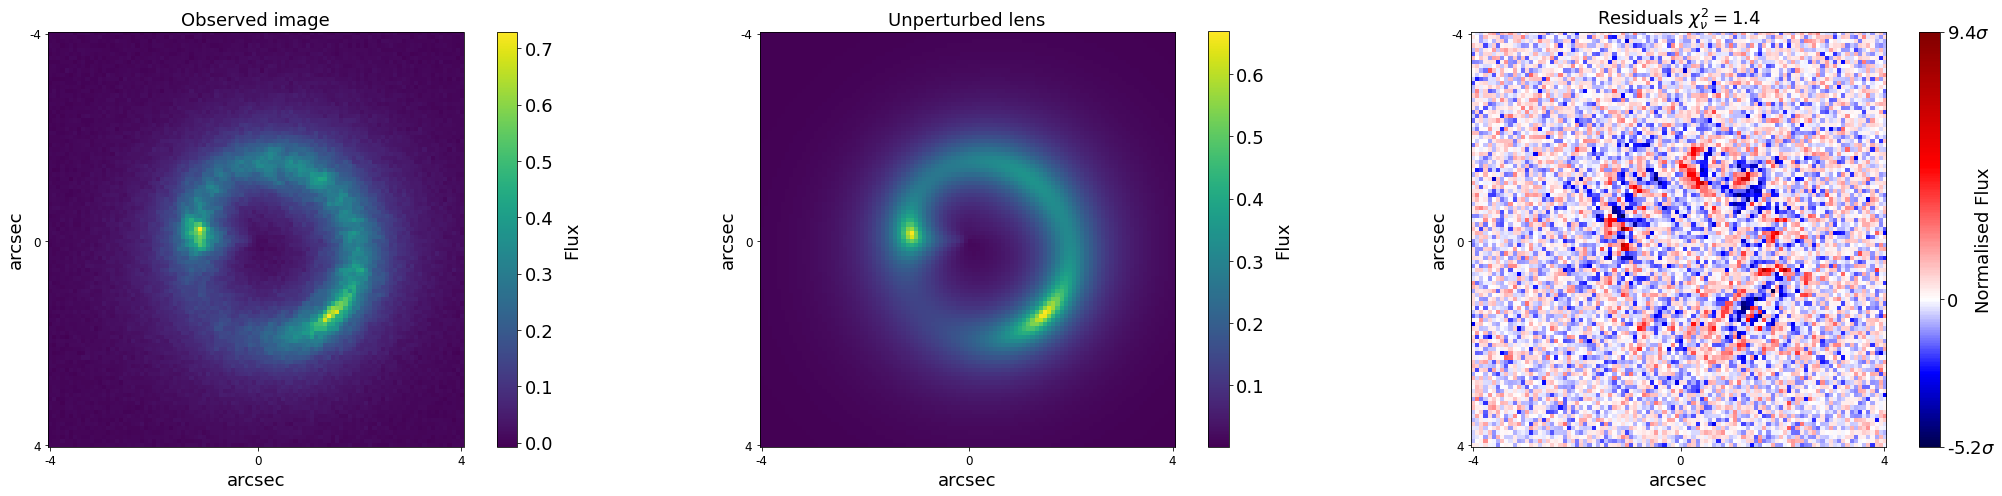

In [8]:
# get function that simulates unperturbed gravitational lens
simulate_unperturbed_image=Surface_brightness.unperturbed_image_getter

Unperturbed_image=simulate_unperturbed_image(kwargs_unperturbed_model,Noise_flag=False) # Image of Einstein ring with no perturbations and noise
Observed_anomalies=Observed_image-Unperturbed_image # Fit residuals that should approximate perturbations and noise


fig,ax=plt.subplots(1,3,figsize=(30,7))

Normalised_residuals=Observed_anomalies/np.sqrt(Surface_brightness.noise_var)
images=[Observed_image,Unperturbed_image,Normalised_residuals]
titles=['Observed image','Unperturbed lens','Residuals '+r'$\chi^2_{\nu}=$'+'{:.1f}'.format((Normalised_residuals**2).sum()/(Normalised_residuals.size-1))]

# Observed and fitted images
for i in range(2):
    img_figure=ax[i].imshow(images[i])
    cbar=fig.colorbar(img_figure,ax=ax[i],fraction=0.045)
    cbar.ax.tick_params(labelsize=FS)
    cbar.ax.set_ylabel('Flux',rotation=90,fontsize=FS,labelpad=10)

# Normalised residuals (i.e. perturbations normalised by noise map)
img_figure=ax[2].imshow(Normalised_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
colorborders=[math.ceil(Normalised_residuals.min()*1e+1)/1e+1,0,math.floor(Normalised_residuals.max()*1e+1)/1e+1]
ticksborders=[math.ceil(Normalised_residuals.min()*1e+2)/1e+2,0,math.floor(Normalised_residuals.max()*1e+2)/1e+2]
cbar=fig.colorbar(img_figure,ax=ax[2],ticks=ticksborders,fraction=0.045)
cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=FS,labelpad=-20)
cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'],fontsize=FS)


for i,title in enumerate(titles):
    ax[i].set_title(title,fontsize=FS)
    ax[i].set_xticks([0,50,100-1])
    ax[i].set_xticklabels([-4,0,4],fontsize=12)
    ax[i].set_yticks([0,50,100-1])
    ax[i].set_yticklabels([-4,0,4],fontsize=12)
    ax[i].set_xlabel('arcsec',fontsize=FS)
    ax[i].set_ylabel('arcsec',fontsize=FS)

plt.tight_layout()
plt.show()

So we see that unperturbed model indeed can not fully describe the observed image, so we significantly detect the anomalies $\delta I$.
We can quantify those anomalies in terms of their radial power spectrum $P_{\delta I}(|k|)$

# Gradient descent-based optimization of potential inhomogeneities

So in these section we will optimize power spectrum of gravitational potential inhomogeneities $P_{\delta \psi}$ using gradient descent optimization.
Though we are not interested in random seed $\phi$, so we will sample inhomogeneities for many $\phi$ and construct likelihood to account for $\phi$-defined variation as for the noise
Given the parameters of the unperturbed model we can define all the classes that we will need for further this process.

## Radial power spectrum of the observed anomalies

In [7]:
from GRF_perturbations.Modules.GRF_inhomogeneities_class import GRF_inhomogeneities_class # Class that handles generation of GRF
from GRF_perturbations.Modules.Inference_class import Inference_class # Class that handles all the inference related procedures

#How many random seeds phi to use in the inference
Phase_seeds_number=400  # it should be big enough to ensure statistical significance of mean and variance of the anomalies power spectrum
GRF_class=GRF_inhomogeneities_class(pixel_number, pixel_scale, Phase_seeds_number)

# Renew the model of unperturbed lens to the fitted one
Surface_brightness=Surface_brightness_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time,supersampling_factor,
                                            source_light_model_list,kwargs_unperturbed_model['kwargs_source'],
                                            lens_mass_model_list,kwargs_unperturbed_model['kwargs_lens'],
                                            lens_light_model_list,kwargs_unperturbed_model['kwargs_lens_light'])

# In order to account for absorption of anomalies on the stage of lens fitting that class can also fit lens
# In Gradient descent-based optimization we will not use this fitting due to high computation load
Inference=Inference_class(GRF_class,Surface_brightness,Grad_descent_max_iter=0)

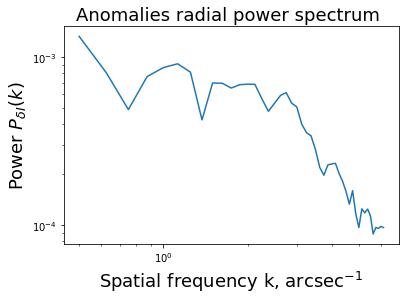

In [8]:
Data_spectrum=Inference.compute_radial_spectrum(Observed_anomalies) # This function computes radial power spectrum of anomalies withing Einstein ring region
plt.loglog(Surface_brightness.frequencies,Data_spectrum)
plt.xlabel('Spatial frequency k, arcsec'+r'$^{-1}$',fontsize=FS)
plt.ylabel('Power '+r'$P_{\delta I}(k)$',fontsize=FS)
plt.title('Anomalies radial power spectrum ',fontsize=FS)
plt.show()

## Likelihood and Loss function

This is the quantity that we will fit. Specifically we will search for maximum likelihood assuming uniform priors on $A$ and $\beta$ of $P_{\delta \psi}[A,\beta,\phi](k)$
$p(A,\beta | I(\vec{x})) \propto \prod_{k} p(P_{\delta I}(k) \ | \ log \mathcal{N}(\mu_{A,\beta}(k),\sigma^2_{A,\beta}(k)))$

with mean and variance of radial anomalies power spectrum estimated from many samples with different GRF random seed $\phi$ and different observation noise realisations

$\mu_{A,\beta}(k)= \frac{1}{N_{\phi}} \sum_{\phi} \log{ (P_{\delta I}[A,\beta,\phi](k))}$,

$\sigma^2_{A,\beta}(k)= \frac{1}{N_{\phi}-1} \sum_{\phi} \left( \log{ (P_{\delta I}[A,\beta,\phi](k))} - \mu_{A,\beta}(k)\right)^2$

this is negative log-likelihood $-2logp(A,\beta | I(\vec{x}))=\chi^2(A,\beta)$

In [10]:
# the first argument stands for the set of Power spectra
def Spectra_Loss_Chi_sq(Model_spectra,Data_spectrum,Phase_seeds_number):

    data_log_spectrum=jnp.log(Data_spectrum)
    models_log_spectra=jnp.log(Model_spectra)

    Mean_logN=models_log_spectra.mean(axis=-2) #Mu_A.Beta
    Sigma_logN=jnp.sqrt(jnp.power(models_log_spectra-Mean_logN,2).sum(axis=-2)/(Phase_seeds_number-1)) #Sigma_A,Beta

    #Chi^2 loss for Normal likelihood of log-Power spectrum log(P[A,Beta])
    return jnp.mean(jnp.power((data_log_spectrum - Mean_logN)/Sigma_logN, 2), axis=-1)

Spectra_Loss_function=lambda Model_spectra: Spectra_Loss_Chi_sq(Model_spectra,Data_spectrum,Phase_seeds_number) # Pure Loss as a function of anomalies power spectra
GRF_Loss=jax.jit(lambda GRF_params: Inference.GRF_Power_Spectrum_Loss(GRF_params,Phase_seeds_number,Spectra_Loss_function,fit_image=False)) # Pure Loss as a function of logA and Beta
GRF_grad_Loss=jax.jit(jax.grad(GRF_Loss)) # Gradient of Loss function
GRF_hessian_Loss=jax.jit(jax.jacfwd(jax.jacrev(GRF_Loss))) # Hessian of Loss function

So now we have all set of functions needed for gradient descent $\chi^2(A,\beta)$, $\vec{\nabla} \ \chi^2(A,\beta)$, $\vec{\nabla} \vec{\nabla} \ \chi^2(A,\beta)$
Let's test how long it takes to evaluate the values

In [11]:
import time
start_time=time.time()

print('Loss={:.2f}'.format(GRF_Loss([-7.6,2.])),'evaluation time={:.2f} sec'.format(time.time()-start_time))
start_time=time.time()
print('Gradient of Loss= ',np.array(GRF_grad_Loss([-7.6,2.])).round(2),'evaluation time={:.2f} sec'.format(time.time()-start_time))
start_time=time.time()
print('Hessian of Loss= ',np.array(GRF_hessian_Loss([-7.6,2.])).flatten().round(2),'evaluation time={:.2f} sec'.format(time.time()-start_time))

Loss=0.94 evaluation time=10.14 sec
Gradient of Loss=  [-5.08  2.72] evaluation time=6.23 sec
Hessian of Loss=  [114.44 -50.69 -50.69  26.33] evaluation time=15.20 sec


The evaluation of the functions is quite fast.
Now let us define the bounds of the region in which we want to use our algorithm

## Bounds on $log(A)$ and $\beta$

### Bounds on $\beta$

Minimal $\beta$ would correspond to flat field GRF $\delta \psi$, so $\beta_{min}=0$

Since $\beta$ defines scale of perturbations $\lambda$ we constrain it from above based on condition $\lambda<\theta_{E}$, where $\theta_{E}$ is the Einstein radius of the unperturbed lens.
Estimation of $\lambda$ can be found from Lagrange's Mean Value Theorem for the potential perturbations Power spectrum:
$\int PS(k) dk_x dk_y = PS(\widetilde{k}) \int dk_x dk_y $

$\widetilde{\lambda}=\frac{1}{\widetilde{k}}=\left(\frac{\sum_{k_x} \sum_{k_y} k^{-\beta}}{N^2}\right)^{\frac{1}{\beta}}$


In [12]:
betas=np.linspace(0.1,6,90)

def get_true_scale(beta):
    total_energy=GRF_class.field_variance([0.,beta],field='potential')
    scale=jnp.power(total_energy/(GRF_class.pixel_number**2),1/beta)
    return scale

scales=np.vectorize(get_true_scale)(betas)
theta_E=Surface_brightness.kwargs_unperturbed_model['kwargs_lens'][0]['theta_E']
minimal_Beta=0
maximal_Beta=betas[np.argmin(np.abs(scales-theta_E))]
print('Minimal Beta={:.1f}'.format(minimal_Beta))
print('Maximal Beta={:.1f}'.format(maximal_Beta))

Minimal Beta=0.0
Maximal Beta=4.7


## Bounds on $log(A)$

Potential inhomogeneities $\delta \psi$ should be perturbations of the main lens gravitational potential $\psi$, however they should still alter the result Einstein ring.
We put bounds on amplitude of potential inhomogeneities $\delta \psi$ in terms of corresponding differential deflection $\delta \alpha$.
For $\delta \psi$ effect to be notable the minimal deflection should be greater than the pixel scale: $\delta \alpha (A_{min},\beta_{min})=pixel\_scale$
For $\delta \psi$ to be a perturbation of $\psi$ the perturbation deflection should be much less than Einstein radius: $\delta \alpha (A_{max},\beta_{max})=0.2 \times \theta_E$

The extraction of log(A) is quite easy for $\delta \alpha (A,\beta)=\sqrt{A} \times \delta \alpha (0,\beta)$


In [13]:
#dalpha(0,beta)
def maximal_deflection_for_unitA(beta):
    alphas=np.zeros((2,Phase_seeds_number,pixel_number,pixel_number))
    alphas[0]=[GRF_class.alpha([0.,beta],GRF_class.tensor_unit_Fourier_images[i],direction='y') for i in range(Phase_seeds_number)] #d(psi)/dy
    alphas[1]=[GRF_class.alpha([0.,beta],GRF_class.tensor_unit_Fourier_images[i],direction='x') for i in range(Phase_seeds_number)] #d(psi)/dx
    absolute_alpha=np.sqrt(alphas[0]**2+alphas[1]**2) # |nabla psi|
    return absolute_alpha.max(axis=(1,2)).mean() # maximal deflection averaged over GRF random seeds

minimal_logA=np.log10((pixel_scale/maximal_deflection_for_unitA(0.))**2)
maximal_logA=np.log10((0.2*theta_E/maximal_deflection_for_unitA(4.7))**2)
print('Minimal log(A)={:.2f}'.format(minimal_logA))
print('Maximal log(A)={:.2f}'.format(maximal_logA))

Minimal log(A)=-10.35
Maximal log(A)=-7.02


## Gradient descent optimization of $log(A)$ and $\beta$

Now we just need to minimize our Loss function within the selected bounds.
In scipy.optimize.minimize only one 'trust-constrained' method can simultaneously use hessian and support bounds

In [14]:
import scipy
step = 1 # fitting Step number
history=np.zeros((0,2)) # history of arguments
loss_history=np.zeros(0) # history of losses
bounds=((minimal_logA, maximal_logA), (minimal_Beta, maximal_Beta)) # Bounds from the previous section
initial_args=[minimal_logA,(maximal_Beta+minimal_Beta)/2] # Start from almost no inhomogeneities with somewhat average spatial scale

def callbackF_trust_constr(Xi,optimizer):
    global step
    global history
    global loss_history

    if step==1:
        print(' step      logA        Beta        Loss       dL/dlogA      dL/dBeta')

    loss=GRF_Loss(Xi)
    grad=GRF_grad_Loss(Xi)
    print('{0:4d}      {1:3.3f}      {2: 3.3f}      {3: 3.3f}      {4: 3.3f}      {5: 3.3f}'.format(step, Xi[0], Xi[1], loss,grad[0],grad[1]))

    step += 1
    loss_history=np.append(loss_history,optimizer.fun)
    history=np.append(history,[Xi],axis=0)

res=scipy.optimize.minimize(GRF_Loss,initial_args,method='trust-constr',jac=GRF_grad_Loss,hess=GRF_hessian_Loss,
                            bounds=bounds,options={'disp': True},callback=callbackF_trust_constr,tol=0.001)

 step      logA        Beta        Loss       dL/dlogA      dL/dBeta
   1      -10.355       2.337       78.294      -2.163       0.466
   2      -9.615       2.187       75.789      -11.529       3.182
   3      -8.225       1.613       13.149      -45.169       19.529
   4      -8.225       1.613       13.149      -45.169       19.529
   5      -7.996       0.496       12.324       54.917      -34.929
   6      -7.925       1.113       2.230       9.154      -7.445
   7      -7.575       1.894       0.853       3.789      -1.750
   8      -7.593       1.920       0.809      -0.102       0.110
   9      -7.593       1.920       0.809      -0.102       0.110
  10      -7.600       1.903       0.770       0.020       0.037
  11      -7.600       1.903       0.770       0.020       0.037
  12      -7.600       1.903       0.770       0.020       0.037
  13      -7.600       1.903       0.770       0.020       0.037
  14      -7.600       1.903       0.770       0.020       0.037
  15    

## Best fit results

First let's take a look at the model of spectrum that we have obtained and compare it to the data that we observed

In [15]:
from GRF_perturbations.Modules.Utils import jax_map # jaxified function map(f,arr)
getter_SB_Anomalies_spectra=jax.jit(lambda unit_Fourier_image: Inference.Anomalies_Radial_Power_Spectrum(res.x,unit_Fourier_image, Noise_flag=True,fit_image=False)) # get P_dI for A,beta,phi
SB_Anomalies_spectra=jax_map(getter_SB_Anomalies_spectra,GRF_class.tensor_unit_Fourier_images) # map the getter over random seeds phi

Mean_logN=np.log(SB_Anomalies_spectra).mean(axis=-2) # Mean log(Spectrum) in the best fit log(A) and Beta
Sigma_logN=jnp.sqrt(jnp.power(np.log(SB_Anomalies_spectra)-Mean_logN,2).sum(axis=-2)/(len(SB_Anomalies_spectra)-1)) # Uncertainty of log(Spectrum) in the best fit log(A) and Beta

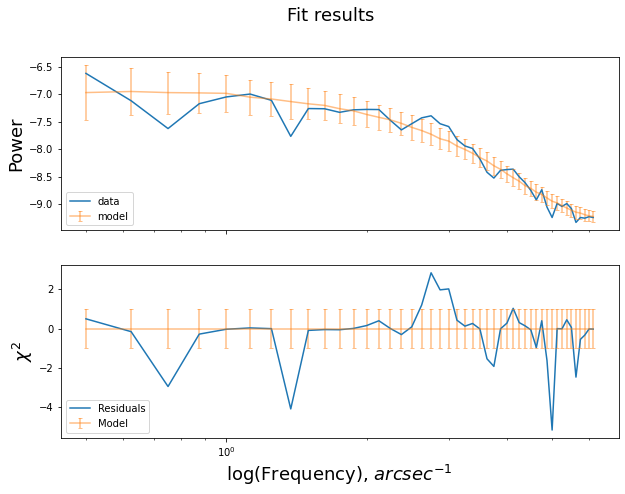

In [16]:
fig,ax=plt.subplots(2,1,figsize=(10,7),sharex=True)

Data_log_spectrum=np.log(Data_spectrum)
ax[0].plot(Surface_brightness.frequencies,Data_log_spectrum,label='data')
ax[0].errorbar(Surface_brightness.frequencies,Mean_logN,Sigma_logN,capsize=2,alpha=0.5,label='model')
ax[0].set_ylabel('Power',fontsize=FS)

Chi_sq=jnp.power((Data_log_spectrum-Mean_logN)/Sigma_logN,2)*np.sign(Data_log_spectrum-Mean_logN)
ax[1].plot(Surface_brightness.frequencies,Chi_sq,label='Residuals')
ax[1].errorbar(Surface_brightness.frequencies,np.zeros_like(Chi_sq),np.ones_like(Chi_sq),capsize=2,alpha=0.5,label='Model')
ax[1].set_xlabel('log(Frequency), '+r'$arcsec^{-1}$',fontsize=FS)
ax[1].set_ylabel(r'$\chi^2$',fontsize=FS)
ax[1].set_xticks([-4,-2,0,2])
ax[1].set_xticklabels([str(x)+r'$\sigma$' for x in[-4,-2,0,2]])


for i in range(2):
    ax[0].set_xscale('log')
    ax[i].legend(loc='lower left')

fig.suptitle('Fit results',fontsize=FS)
plt.show()

The fit is relatively good, but the fact that residuals reach the value of $4\sigma$ point that it is not perfect
Let's now take a look at confidence ellipsis. We can get one by approximating covariance matrix with Fisher matrix.
In a turn, Fisher matrix can be evaluated from chi^2 (Loss) hessian (https://arxiv.org/pdf/0906.4123.pdf)

$F=\frac{1}{2} \begin{bmatrix} \frac{\partial^2}{\partial x^2} & \frac{\partial^2}{\partial x \partial y} \\ \frac{\partial^2}{\partial x \partial y} & \frac{\partial^2}{\partial y^2} \\ \end{bmatrix} \chi^2$ ,


$\Sigma=\begin{bmatrix} \sigma_x^2 & \sigma_{xy} \\ \sigma_{xy} & \sigma_y^2 \\ \end{bmatrix} \approx F^{-1}$

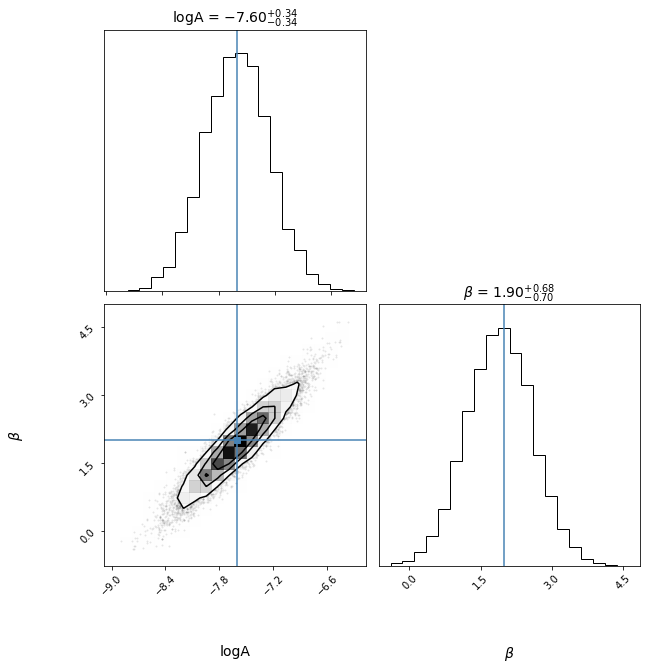

In [17]:
fisher_matrix = 1/2*GRF_hessian_Loss(res.x)
covariance_matrix= jnp.linalg.inv(fisher_matrix)

import corner
# Sample a lot of points from the covariance matrix
def draw_from_gaussian(mu, S, ndraws=1):
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

samples_fisher = draw_from_gaussian(res.x, covariance_matrix, ndraws=10000)

fig = plt.figure(figsize=(10, 10))
fig = corner.corner(samples_fisher, truths=[-7.6,2.], show_titles=True, labels=['logA',r'$\beta$'],
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()

Very nice! But now let's explore much more complete and accurate method

# Grid based optimization of potential inhomogeneities

The other method is to compute $P_{\delta I}[A,\beta,\phi]$ for all the $A$ and $\beta$ withing bounds and for such number of random seeds $\phi$ that would ensure statistical significance if the results.

In [14]:
grid_size=128 # resolution of logA,Beta axes
logA_array=np.linspace(-10.075,-6.9,grid_size)
Beta_array=np.linspace(0,4.7,grid_size)
Phase_seeds_number=100 # number of random seeds that would ensure statistical significance of estimated spectrum mean and uncertainties

Now we redefine Inference class. Specificaly, it should redo unperturbed source-lens fitting procedure for every $log(A)$,$\beta$ and $\phi$ as in the section 'Extracting surface brightness anomalies $\delta I$',
but using simple gradient descent with limited number of steps. This procedure should account for possible absorption of surface brightness anomalies and noise on the stage of anomalies extraction.

In [15]:
from GRF_perturbations.Modules.Utils import jax_pmap_over_grid
# Handling GRF generation
GRF_class=GRF_inhomogeneities_class(pixel_number, pixel_scale, Phase_seeds_number)
# Handling generation of surface brightness of perturbed Einstein ring
Surface_brightness=Surface_brightness_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time,supersampling_factor,
                                            source_light_model_list,kwargs_unperturbed_model['kwargs_source'],
                                            lens_mass_model_list,kwargs_unperturbed_model['kwargs_lens'],
                                            lens_light_model_list,kwargs_unperturbed_model['kwargs_lens_light'])
# Handling all the inference-related procedures
Inference=Inference_class(GRF_class,Surface_brightness,Grad_descent_max_iter=1000) # Set 1000 steps of source-lens fitting gradient descent

# Set of functions that map the anomalies power spectrum getter over a given dimension of the log(A),Beta,phi grid
compute_anomalies_spectrum_pure=lambda logA,Beta,Fourier_phase: Inference.Anomalies_Radial_Power_Spectrum(jnp.array([logA,Beta]),Fourier_phase)
#Parallel mapping of given function over given logA_array,Beta_array,random_seed. Computation is parallelized over logA_array
compute_spectra_grid_batch=lambda logA_array_batch: jax_pmap_over_grid(compute_anomalies_spectrum_pure,logA_array_batch,Beta_array,np.arange(Phase_seeds_number))

In [16]:
start_time=time.time()
_=compute_anomalies_spectrum_pure(-7.6,2.,GRF_class.tensor_unit_Fourier_images[0])
print('Computation for one set of log(A),Beta,phi took {:.2f} seconds'.format(time.time()-start_time))

Computation for one set of log(A),Beta,phi took 5.91 seconds


With selected grid resolution and random phases number we have to do approximately 1.5 million of such computations.
Hence, it should be done on cluster or GPU in parallelized manner as it is shown done in the scripts in the folder '../Processing_scripts'

For this computation we used 4 nodes of cluster, which had 16 Intel Xeon (E5-2640 v3, 2.6GHz) cores per node and 128GB (2133 MHz) of memory per node.
The whole computation was parallelized between 4 nodes and for every node it was parallelized on 32 threads with the hyper-threading.
The whole computation took  approximately 2 days.

In [17]:
#Parallel mapping of given function over given logA_array,Beta_array,random_seed. Computation is parallelized over logA_array
#Spectra_grid_batch=compute_spectra_grid_batch(logA_array[:max_thread_numbers]) # Parallelized computation Batched according to the number of processing units
#Spectra_grid=compute_spectra_grid_batch(logA_array) # What we would get by uniting all the batches from the function above

#The grid computed for the unperturbed Source-Lens setup used in this notebook
Spectra_grid=np.load('../Processing_scripts/results/Spectra_grid.npz')['arr_0']

In [18]:
from GRF_perturbations.Modules.Spectra_grid_processing import compute_SNR_grid,Infer_GRF,plot_Inference_results
#from GRF_perturbations.Modules.Inference import infer_LogNorm_params,Inference_pipeline,compute_SNR_grid,plot_likelihood,get_conf_intervals,Spectra_Loss,compute_Loss_grid

# Statistics of the noise
Estimated_Noise_spectral_density=(Surface_brightness.noise_var*Surface_brightness.annulus_mask).sum()/Surface_brightness.annulus_mask.sum()
#Map of SNRs for all the A,beta combinations
SNR_grid=compute_SNR_grid(Spectra_grid,Estimated_Noise_spectral_density)
Likelihood_grid,Confidence_grid,logA_pred_index,Beta_pred_index,logA_conf_intervals,Beta_conf_intervals=Infer_GRF(Data_spectrum,Spectra_grid)

/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Spectra_grid_processing.py:26: RuntimeWarning: invalid value encountered in log10
  SNR=10*np.log10(np.mean(Spectra_grid-Noise_spectral_density,axis=-1)/Noise_spectral_density)


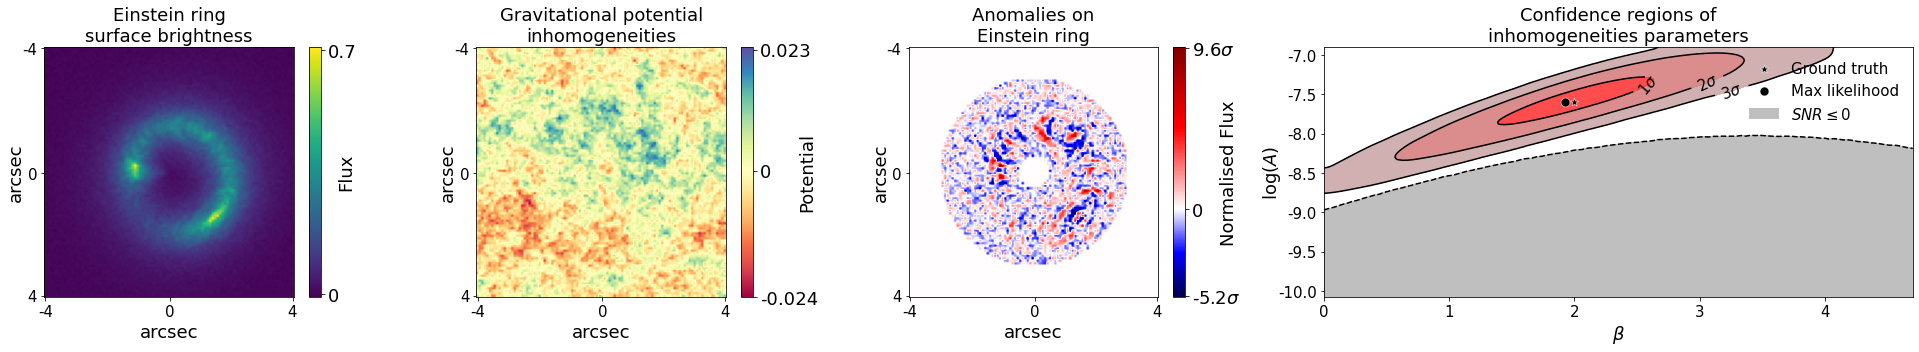

In [19]:
GRF_params=[-7.6,2]

GRF_potential=GRF_class.potential(GRF_params,GRF_class.tensor_unit_Fourier_images[0])

logA_true_index=np.argmin(np.abs(logA_array-GRF_params[0]))
Beta_true_index=np.argmin(np.abs(Beta_array-GRF_params[1]))

from matplotlib import gridspec
fig=plt.figure(figsize=(27,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1])
ax=[]
for i in range(1):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]

ax=np.array(ax)

#ylabel=r"${\rm log}(A)$"+"={:.1f}".format(GRF_params[0])+'\n'+r'$\beta=$'+'{:.0f}           \n'.format(GRF_params[1])+'Phase={:.0f}    '.format(GRF_seed_index)
ylabel=''

confidence_labels_locations=[[(4,-10)],[(4,-10)],[(4,-10)]]
plot_Inference_results(fig,ax[0],Surface_brightness,logA_array,Beta_array,Observed_image,Observed_anomalies,GRF_potential,
                       Likelihood_grid,Confidence_grid,SNR_grid,logA_true_index,Beta_true_index,confidence_labels_locations)
plt.tight_layout(h_pad=3,w_pad=2)

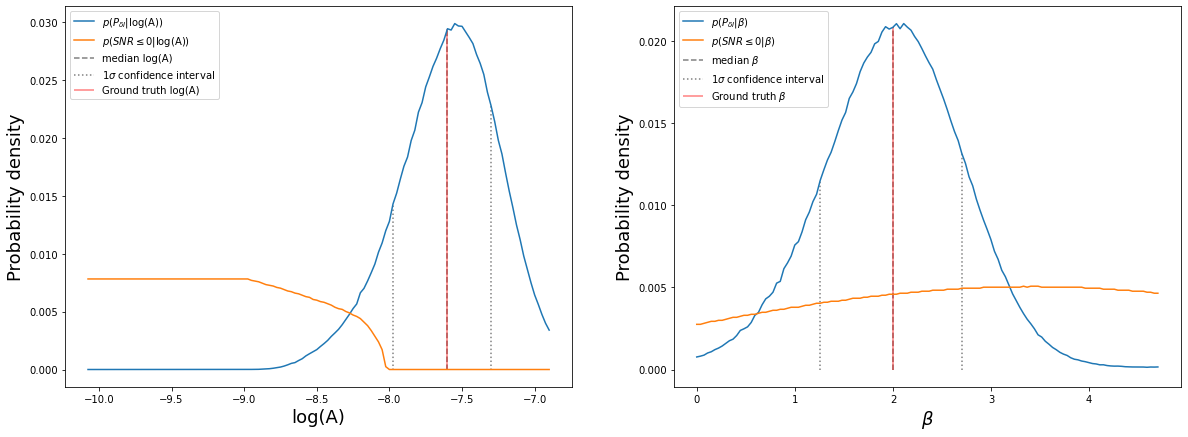

In [20]:
parameter_arrays=[logA_array,Beta_array]
predictions=[logA_pred_index,Beta_pred_index]
confidence_intervals=[logA_conf_intervals,Beta_conf_intervals]

title_arg=['log(A)',r'$\beta$']
arg_array=[logA_array,Beta_array]
true_value=[-7.6,2]

fig,ax=plt.subplots(1,2,figsize=(20,7))

ax[0].set_xlabel('log(A)',fontsize=FS)
ax[1].set_xlabel(r'$\beta$',fontsize=FS)



for i in range(2):
    parameter_array=parameter_arrays[i] # values of parameter (e.g. logA)
    prediction_index=predictions[i] # index of median of 1d likelihood of parameter
    low_confidence_index=confidence_intervals[i][0,0] # index of low 1sigma confidence bound
    high_confidence_index=confidence_intervals[i][0,1] # index of high 1sigma confidence bound

    # if we get likelihood for logA we marginalise over Beta
    marginalization_index=np.logical_not(i).astype(int)
    likelihood_1d=Likelihood_grid.sum(axis=marginalization_index)/Likelihood_grid.sum()
    SNR_1d=(SNR_grid<=0).sum(axis=marginalization_index)/SNR_grid.size

    #Plots
    ax[i].plot(parameter_array,likelihood_1d,label=r'$p(P_{\delta I}|$'+title_arg[i]+'$)$')
    ax[i].plot(parameter_array,SNR_1d,label=r'$p(SNR \leq 0|$'+title_arg[i]+'$)$')

    #median
    ax[i].vlines(parameter_array[prediction_index],0,likelihood_1d[prediction_index],\
                 color='k',linestyle='dashed',alpha=0.5,label='median '+title_arg[i])
    #confidence intervals
    ax[i].vlines(parameter_array[low_confidence_index],0,likelihood_1d[low_confidence_index],\
                color='k',linestyle='dotted',alpha=0.5,label=r'$1\sigma$'+' confidence interval')
    ax[i].vlines(parameter_array[high_confidence_index],0,likelihood_1d[high_confidence_index],\
                color='k',linestyle='dotted',alpha=0.5)
    #Ground truth value
    true_index=np.argmin(np.abs(arg_array[i]-true_value[i]))
    ax[i].vlines(parameter_array[true_index],0,likelihood_1d[true_index],\
                 color='r',alpha=0.5,label='Ground truth '+title_arg[i])
    ax[i].legend(loc='upper left')
    ax[i].set_ylabel('Probability density',fontsize=FS)

In [21]:
print('Ground truth: logA={:.1f}, Beta={:.0f}'.format(*true_value))

title_arg=['log(A)','Beta']
for i in range(2):
    title=title_arg[i] # name of the parameter
    prediction=parameter_arrays[i][predictions[i]] # predicted value for e.g. log(A)
    confidence_values= parameter_arrays[i][list(confidence_intervals[i][0])] # low and high 1sigma confidence values
    print('Predicted {}: {}={:.2f} +{:.2f} -{:.2f}'.format(title,title,prediction,*np.abs(confidence_values-prediction)))

Ground truth: logA=-7.6, Beta=2
Predicted log(A): log(A)=-7.60 +0.38 -0.30
Predicted Beta: Beta=2.00 +0.74 -0.70


The grid-based method predicts correct $log(A)$ and $\beta$, whereas gradient descent-based method underestimated $\beta$ on 0.9.
Also the grid-based method predicts a bit wider uncertainties of $\beta$. Moreover it gives us an opportunity to see how likelihood distributions of $log(A)$ and $\beta$ actually deviate from Gaussians.
This deviation is not major when $log(A)$ and $\beta$ are far from the region bounds, but close to the bounds the deviation might be significant.
